In [71]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
#to render high res images
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# Load Datasets

In [72]:
df = pd.read_csv('bbc-text.csv')
print(df.shape)


(2225, 2)


In [73]:
df = df[~df['category'].isin(['sport', 'politics'])].reset_index(drop=True)
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,entertainment,ocean s twelve raids box office ocean s twelve...
3,entertainment,last star wars not for children the sixth an...
4,entertainment,berlin cheers for anti-nazi film a german movi...
...,...,...
1292,entertainment,top stars join us tsunami tv show brad pitt r...
1293,tech,rings of steel combat net attacks gambling is ...
1294,business,beijingers fume over parking fees choking traf...
1295,business,cars pull down us retail figures us retail sal...


In [74]:
df['category'] = df['category'].replace('entertainment', 'arts')

# Replace "tech" with "engineering"
df['category'] = df['category'].replace('tech', 'engineering')
df.head(15)

,category,text
0,engineering,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,arts,ocean s twelve raids box office ocean s twelve...
3,arts,last star wars not for children the sixth an...
4,arts,berlin cheers for anti-nazi film a german movi...
5,business,virgin blue shares plummet 20% shares in austr...
6,business,crude oil prices back above $50 cold weather a...
7,business,s korean credit card firm rescued south korea ...
8,business,japanese banking battle at an end japan s sumi...
9,engineering,games maker fights for survival one of britain...


## Exploring the Dataset

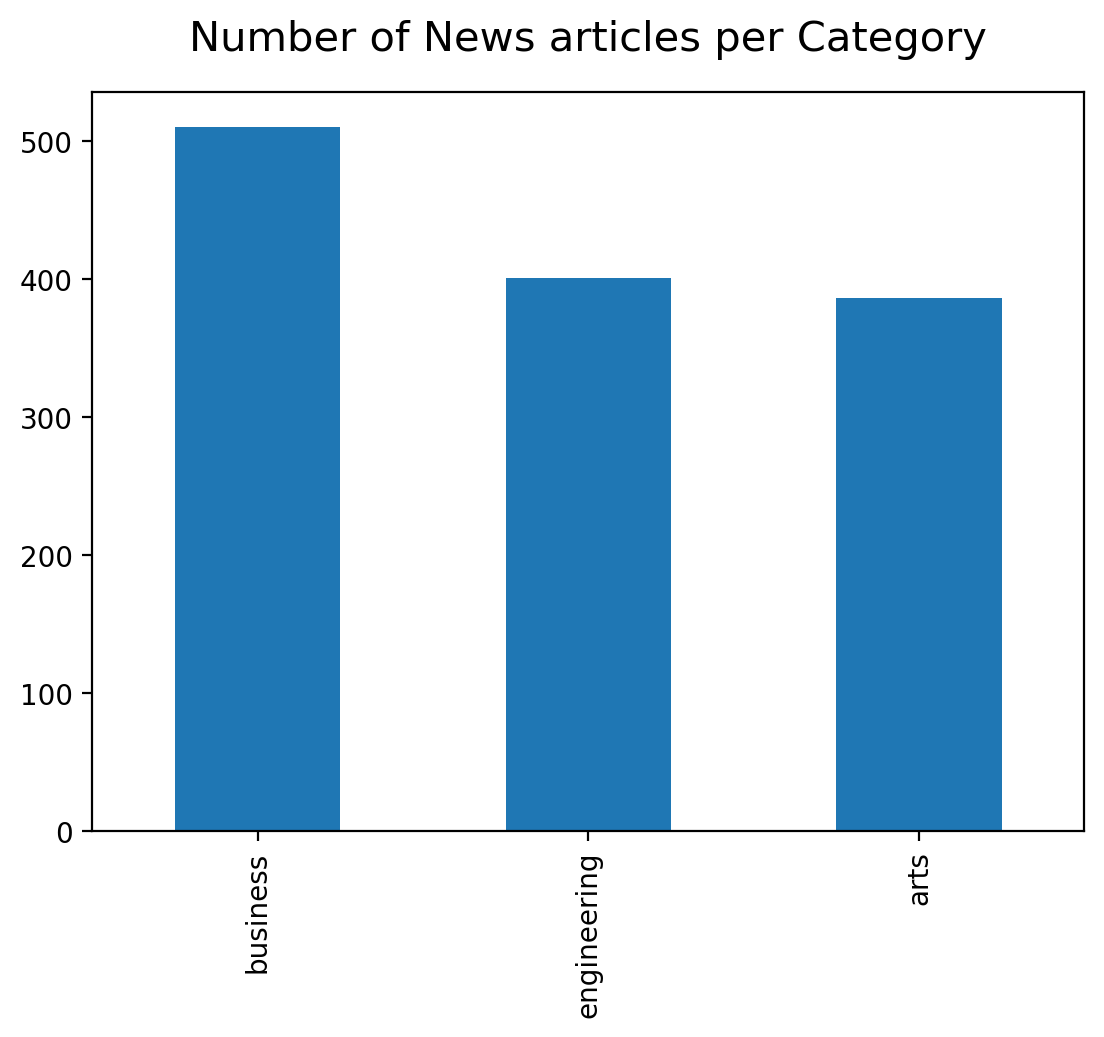

In [77]:
df['category'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=15, pad=15);

text processing step

In [78]:
def text_preprocess(df):
    # Remove special characters
    df['p_text'] = df['text'].replace('\n',' ')
    df['p_text'] = df['p_text'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['p_text'] = df['text'].str.lower()
    df['p_text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['p_text'] = df['p_text'].apply(lematize)

In [80]:
text_preprocess(df)

train test split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df['p_text'], 
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=9)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1037,) (260,) (1037,) (260,)


## Using tfidfvectorizer sklearn

In [82]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

In [83]:
#creating fit model function

def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [84]:
rf_clf = fit_model(RandomForestClassifier(), 'Randf')
svm_clf = fit_model(SVC(), 'SVM')
lgbm_clf = fit_model(LGBMClassifier(), 'LGBM')

rf = pd.DataFrame.from_dict(rf_clf)
sv = pd.DataFrame.from_dict(svm_clf)
lg = pd.DataFrame.from_dict(lgbm_clf)

In [85]:
l1 = [rf, sv, lg]
l2 =["Randf", "SVM", "LGBM"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([rf, sv, lg])

In [86]:
rf_clf

{'fit_time': array([2.07826185, 1.73299861, 1.87087631]),
 'score_time': array([0.20681119, 0.2249999 , 0.17299819]),
 'test_accuracy': array([0.97109827, 0.95375723, 0.97391304]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.9711194 , 0.95374074, 0.97387473]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.97194753, 0.95388294, 0.97472917]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.97109827, 0.95375723, 0.97391304]),
 'train_recall_weighted': array([1., 1., 1.])}

In [87]:
svm_clf

{'fit_time': array([1.80300546, 1.58495378, 1.53505635]),
 'score_time': array([0.63294387, 0.44199872, 0.47800064]),
 'test_accuracy': array([0.97976879, 0.97687861, 0.9826087 ]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.97972236, 0.9768829 , 0.98262483]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.98004298, 0.97707112, 0.98307751]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.97976879, 0.97687861, 0.9826087 ]),
 'train_recall_weighted': array([1., 1., 1.])}

In [88]:
lgbm_clf

{'fit_time': array([2.11006737, 2.39854264, 2.48707151]),
 'score_time': array([0.21600103, 0.26000118, 0.25300169]),
 'test_accuracy': array([0.95953757, 0.94797688, 0.96811594]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.95952149, 0.94812999, 0.9681848 ]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.96009208, 0.94851315, 0.96911688]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.95953757, 0.94797688, 0.96811594]),
 'train_recall_weighted': array([1., 1., 1.])}

In [89]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

random_forest_metrics = joined_output.loc[joined_output.model == 'Randf'][relevant_measures]
svm_metrics = joined_output.loc[joined_output.model == 'SVM'][relevant_measures]
lgbm_metrics = joined_output.loc[joined_output.model == 'LGBM'][relevant_measures]

#### Random Forest metrics

In [90]:
random_forest_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.971098,0.971948,0.971098,0.971119
1,0.953757,0.953883,0.953757,0.953741
2,0.973913,0.974729,0.973913,0.973875


#### SVM Metrics

In [91]:
svm_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.979769,0.980043,0.979769,0.979722
1,0.976879,0.977071,0.976879,0.976883
2,0.982609,0.983078,0.982609,0.982625


#### LGBM Metrics

In [92]:
lgbm_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.959538,0.960092,0.959538,0.959521
1,0.947977,0.948513,0.947977,0.948130
2,0.968116,0.969117,0.968116,0.968185


#### Average metrics

In [93]:
metrics_ = [random_forest_metrics, svm_metrics, lgbm_metrics]
names_ = ['Random Forest', 'SVM', 'LightGBM']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Random Forest Mean Metrics:
test_accuracy              0.966256
test_precision_weighted    0.966853
test_recall_weighted       0.966256
test_f1_weighted           0.966245
dtype: float64
  
SVM Mean Metrics:
test_accuracy              0.979752
test_precision_weighted    0.980064
test_recall_weighted       0.979752
test_f1_weighted           0.979743
dtype: float64
  
LightGBM Mean Metrics:
test_accuracy              0.958543
test_precision_weighted    0.959241
test_recall_weighted       0.958543
test_f1_weighted           0.958612
dtype: float64
  


## Selection of Model : model selected -> SVM

In [94]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [95]:
def model_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [96]:
# Create model
clf = model_fit(SVC(), X, y)

In [97]:
clf.classes_

array(['arts', 'business', 'engineering'], dtype=object)

### The text sample has been taken from the dataset that was collected by crawling the CU Pureportal website. 

Author : Mohamad Nazri Abd Karim,
Lecturer in : Lecturer in Finance
School of Economics, Finance and Accounting

So it should be classified as Business.

Text : Stock Price and Volume Effects Associated with Changes in the Composition of the FTSE Bursa Malaysian KLCI

In [98]:
input_text = input()
clf.predict([input_text])

Stock Price and Volume Effects Associated with Changes in the Composition of the FTSE Bursa Malaysian KLCI


array(['business'], dtype=object)

https://pureportal.coventry.ac.uk/en/publications/loss-and-found-barthes-biography-and-ethical-deficit-in-alexander

Loss and Found: Barthes, Biography and Ethical Deficit in Alexander Gardner’s ‘Portrait of Lewis Payne’.
Damian Sutton

School of Media and Performing Arts

text: 
This article examines the history of Alexander Gardner’s 1865 portrait of Lincoln conspirator Lewis Payne (real name Lewis Powell) and its circulation from the time of its initial production up to 1979, when it was chosen by Roland Barthes as an illustration for his seminal 1980 book Camera Lucida. Barthes chose it as a kind of cipher for the tripartite motif – the studium, the punctum, and the noeme. This study explores the circumstances of the photograph’s production, its precarious existence as an unprinted cast-off, and its discovery in the Library of Congress collection of Civil War photographs. At the heart of the study is Barthes’ famous, but erroneous, description of the photograph, and the question of what we can relearn about this critical image in photographic history. Such a question is framed in terms of the ethical deficit formed by distance, time, and inattention between the viewers of historical images and the people such photographs depict.

In [99]:
input_text = input()
clf.predict([input_text])

This article examines the history of Alexander Gardner’s 1865 portrait of Lincoln conspirator Lewis Payne (real name Lewis Powell) and its circulation from the time of its initial production up to 1979, when it was chosen by Roland Barthes as an illustration for his seminal 1980 book Camera Lucida. Barthes chose it as a kind of cipher for the tripartite motif – the studium, the punctum, and the noeme. This study explores the circumstances of the photograph’s production, its precarious existence as an unprinted cast-off, and its discovery in the Library of Congress collection of Civil War photographs. At the heart of the study is Barthes’ famous, but erroneous, description of the photograph, and the question of what we can relearn about this critical image in photographic history. Such a question is framed in terms of the ethical deficit formed by distance, time, and inattention between the viewers of historical images and the people such photographs depict.


array(['arts'], dtype=object)

https://pureportal.coventry.ac.uk/en/publications/assessing-the-use-of-gold-as-a-zero-beta-asset-in-empirical-asset

Assessing the Use of Gold as a Zero-Beta Asset in Empirical Asset Pricing: Application to the US Equity Market
Muhammad Abdullah, Hussein A. Abdou, Christopher Godfrey, Ahmed A. Elamer, Yousry Ahmed

School of Economics, Finance and Accounting

Text: This paper examines the use of the return on gold instead of treasury bills in empirical asset pricing models for the US equity market. It builds upon previous research on the safe-haven, hedging, and zero-beta characteristics of gold in developed markets and the close relationship between interest rates, stock, and gold returns. In particular, we extend this research by showing that using gold as a zero-beta asset helps to improve the time-series performance of asset pricing models when pricing US equities and industries between 1981 and 2015. The performance of gold zero-beta models is also compared with traditional empirical factor models using the 1-month Treasury bill rate as the risk-free rate. Our results indicate that using gold as a zero-beta asset leads to higher R-squared values, lower Sharpe ratios of alphas, and fewer significant pricing errors in the time-series analysis. Similarly, the pricing of small stock and industry portfolios is improved. In cross-section, we also find improved results, with fewer cross-sectional pricing errors and more economically meaningful pricing of risk factors. We also find that a zero-beta gold factor constructed to be orthogonal to the Carhart four factors is significant in cross-section and helps to improve factor model performance on momentum portfolios. Furthermore, the Fama–French three- and five-factor asset pricing models and the Carhart model are all improved by these means, particularly on test assets which have been poorly priced by the traditional versions. Our results have salient implications for policymakers, governments, central bank rate-setting decisions, and investors.

In [100]:
input_text = input()
clf.predict([input_text])

This paper examines the use of the return on gold instead of treasury bills in empirical asset pricing models for the US equity market. It builds upon previous research on the safe-haven, hedging, and zero-beta characteristics of gold in developed markets and the close relationship between interest rates, stock, and gold returns. In particular, we extend this research by showing that using gold as a zero-beta asset helps to improve the time-series performance of asset pricing models when pricing US equities and industries between 1981 and 2015. The performance of gold zero-beta models is also compared with traditional empirical factor models using the 1-month Treasury bill rate as the risk-free rate. Our results indicate that using gold as a zero-beta asset leads to higher R-squared values, lower Sharpe ratios of alphas, and fewer significant pricing errors in the time-series analysis. Similarly, the pricing of small stock and industry portfolios is improved. In cross-section, we also 

array(['business'], dtype=object)

https://pureportal.coventry.ac.uk/en/publications/efficacy-of-the-4f-feedback-model-a-game-based-assessment-in-univ

Sara de Freitas, Victoria Uren, Kristian Kiili, Manuel Ninaus, Panagiotis Petridis, Petros Lameras, Ian Dunwell, Sylvester Arnab, Stephen Jarvis, Kam Star

Research Centre in Postdigital CulturesSchool of Computing, Mathematics and Data Sciences
Aston UniversityCollege of Policing Tampere University of TechnologyUniversity of GrazUniversity of SuffolkIndependent Researcher

Text: Feedback is a critical aspect of optimised learning design, but there are few, if any, feedback models that map different types of feedback and how they may assist students to increase performance and enhance their learning experience. This research paper outlines a feedback model as an extension of the four-dimensional framework which includes a consideration of the type, the content, the format, and the frequency of feedback, as well as the agent which delivers it. This model is based upon an understanding of learning in the context of designing learning experiences and utilises a game-based model of learning to understand the importance of motivation and autonomy in learners to enhance and accelerate learning. The framework is developed and reflected upon by analysing two cases: a medical triage case in which the timing and frequency of feedback proved critical, and a business simulation which illuminated the need for a range of types of feedback and to be aware of the possibility of different agents (instructor peer and game) that can deliver feedback. The extended model may help game and learning designers alike to discern different types of feedback, both in games and more generally, in more explicit and nuanced ways.

In [101]:
input_text = input()
clf.predict([input_text])

Feedback is a critical aspect of optimised learning design, but there are few, if any, feedback models that map different types of feedback and how they may assist students to increase performance and enhance their learning experience. This research paper outlines a feedback model as an extension of the four-dimensional framework which includes a consideration of the type, the content, the format, and the frequency of feedback, as well as the agent which delivers it. This model is based upon an understanding of learning in the context of designing learning experiences and utilises a game-based model of learning to understand the importance of motivation and autonomy in learners to enhance and accelerate learning. The framework is developed and reflected upon by analysing two cases: a medical triage case in which the timing and frequency of feedback proved critical, and a business simulation which illuminated the need for a range of types of feedback and to be aware of the possibility o

array(['engineering'], dtype=object)

https://www.nvidia.com/en-us/geforce/news/g-sync-ultra-low-motion-blur-2/

ULMB 2 provides full refresh rate backlight strobing and significantly brighter images, all while maintaining pristine image quality. With the panel response time improvements from our partners at AUO, ULMB 2 gives competitive gamers the motion clarity needed to perform at peak levels by keeping them in the game when moments get chaotic.

In [102]:
input_text = input()
clf.predict([input_text])

ULMB 2 provides full refresh rate backlight strobing and significantly brighter images, all while maintaining pristine image quality. With the panel response time improvements from our partners at AUO, ULMB 2 gives competitive gamers the motion clarity needed to perform at peak levels by keeping them in the game when moments get chaotic.


array(['engineering'], dtype=object)